**Samuel Atilano**

Spring 2025

CS 343: Neural Networks

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

TensorFlow version: 2.19.0
Num GPUs Available: 0


## TensorFlow install test

*Sanity check that TensorFlow is installed correctly:*

Executing the following cell should print 3 

In [3]:
tf.print(tf.reduce_sum([tf.constant(1), tf.constant(2)]))

3


# Project 4 | Transfer Learning

## Task 1: Implement ConvNet4AccelV2 in TensorFlow

Construct the familiar `ConvNet4AccelV2` neural network architecture from last project in TensorFlow's high level `Keras::Sequential` API. Also like your last project, train on the STL-10 training set and test on the STL-10 test set.

### 1a. Use the high level `Keras::Sequential` API in TensorFlow to implement the architecture of ConvNet4AccelV2 from the last project. Train and test your network on the STL-10 dataset. 

**Goal:** Achieve ≥ 47% on either the validation set or test set. *For our purposes, getting ≥ 47% validation accuracy at any point during training is enough (i.e. doesn't need to be at the very end of training).*

#### Notes

- You should use the usual STL-10 data acquisition and preprocessing code from your last project. You can use the default split, or modify it yourself.
- You don't need to do a hyperparameter search. Values that worked on the CNN project should get you in the ballpark here. The goal is to show that you know how to put together a `keras::Sequential` model and have it work successfully.
- You may have to tweak the hyperparameters by hand a little (number of epochs, regularization, number of hidden units, etc.) to hit your accuracy target, but it should not take too much effort.
- TensorFlow needs the RGB color channel AFTER the spatial dimensions. For example: (32, 32, 3), not (3, 32, 32). You may therefore need to slightly modify the preprocesssing pipeline for this project.

#### Keras Sequential workflow

Recall the `Keras::Sequential` common workflow:

- Build structure of network with `Keras::Sequential`.
- Compile network with your choice of optimizer, loss, and metrics.
- Fit the model (remembering to pass in the appropriate training and validation sets). This results a history object that can be used to examine training/validation accuracy and loss.
- Evaluate the model on the test set. This returns test loss and accuracy.

#### Helpful documentation

These documentation pages should be helpful:
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary

In [4]:
import load_stl10_dataset
from preprocess_data import load_stl10

In [14]:
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

load_stl10_dataset.purge_cached_dataset()


# preprocess and create splits
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = load_stl10(
    n_train_samps=4398, n_test_samps=400, n_valid_samps=200, n_dev_samps=2, scale_fact=3)

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)


Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!
Train data shape:  (4398, 32, 32, 3)
Train labels shape:  (4398,)
Test data shape:  (400, 32, 32, 3)
Test labels shape:  (400,)
Validation data shape:  (200, 32, 32, 3)
Validation labels shape:  (200,)
dev data shape:  (2, 32, 32, 3)
dev labels shape:  (2,)


In [37]:
tf.random.set_seed(0)

#Creating the network
net = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape = (32,32,3)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides=2, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2, seed=0),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

net.summary()

#Compiling, Fit, and Evaluate
net.compile(optimizer='adamw', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = net.fit(x_train, y_train, batch_size=25, epochs=10, validation_data=(x_val, y_val))
loss, acc = net.evaluate(x_test, y_test)
print(f'test set Loss: {loss}, test set Accuracy{acc}')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,078 (238.59 KB)

 Trainable params: 61,078 (238.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2510 - loss: 2.0902 - val_accuracy: 0.3300 - val_loss: 1.7137
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3905 - loss: 1.6663 - val_accuracy: 0.3700 - val_loss: 1.5752
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4437 - loss: 1.5058 - val_accuracy: 0.4300 - val_loss: 1.4943
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4922 - loss: 1.3997 - val_accuracy: 0.4400 - val_loss: 1.4677
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5213 - loss: 1.3084 - val_accuracy: 0.4350 - val_loss: 1.4612
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5507 - loss: 1.2537 - val_accuracy: 0.4500 - val_loss: 1.4273
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5674 - loss: 1.1684 - val_accuracy: 0.4800 - val_loss: 1.4100
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5989 - loss: 1.0895 - val_accu

### 1b. Make 2 "high quality" plots showing the following

- Training and validation accuracy (y axis) over training epochs (x axis).
- Training and validation loss (y axis) over epochs (x axis).

A high quality plot consists of:
- A useful title
- X and Y axis labels
- A legend

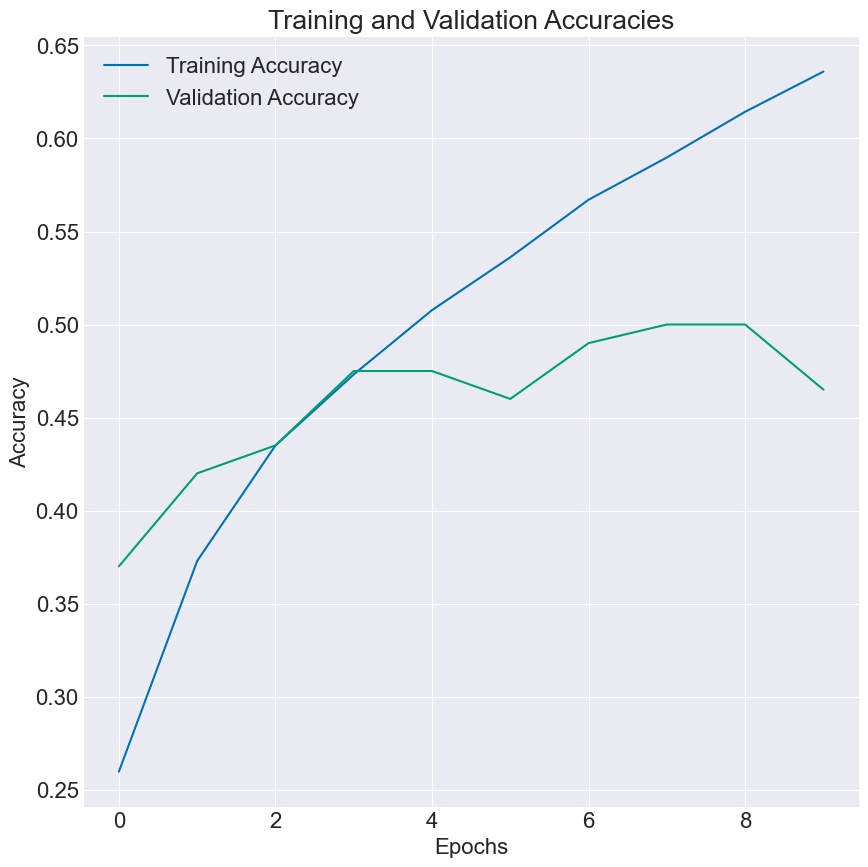

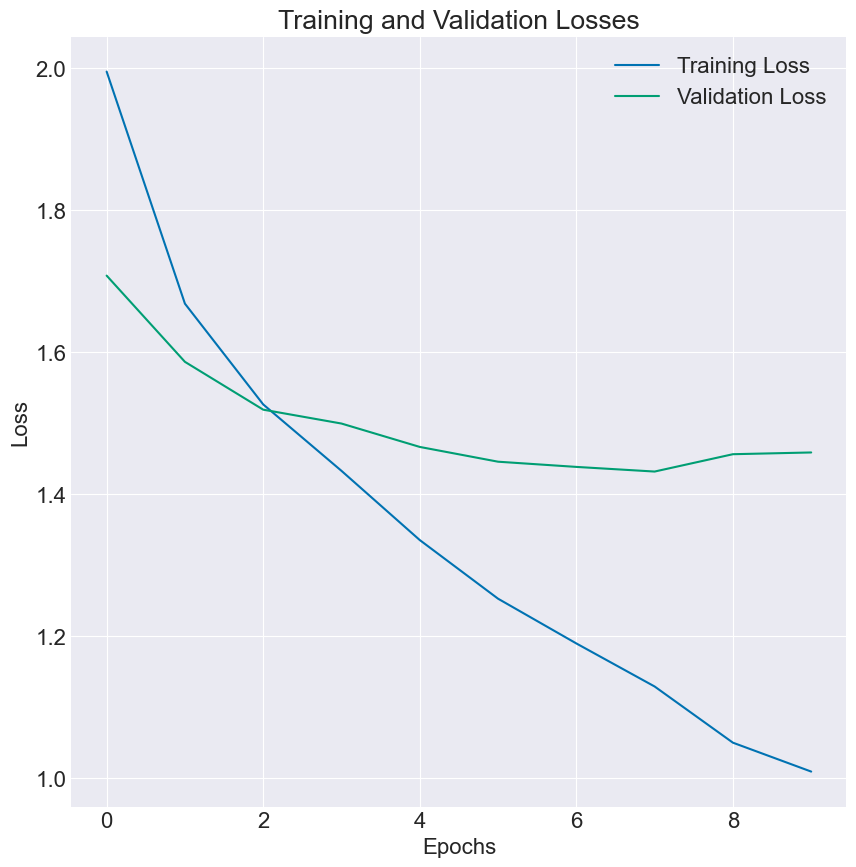

In [6]:
#Extracting loss and accuracies
train_acc = history.history.get('accuracy')
train_loss = history.history['loss']

val_acc = history.history.get('val_accuracy')
val_loss = history.history.get('val_loss')

#Training and Validation Accuracy
plt.figure(figsize=(10,10))
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')

plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training and Validation Loss
plt.figure(figsize=(10,10))
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 1c. Visualize predictions

Make a 5x5 grid of the first 25 images in the test dataset. Label each with the predicted class label string (English label, not an int code).

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


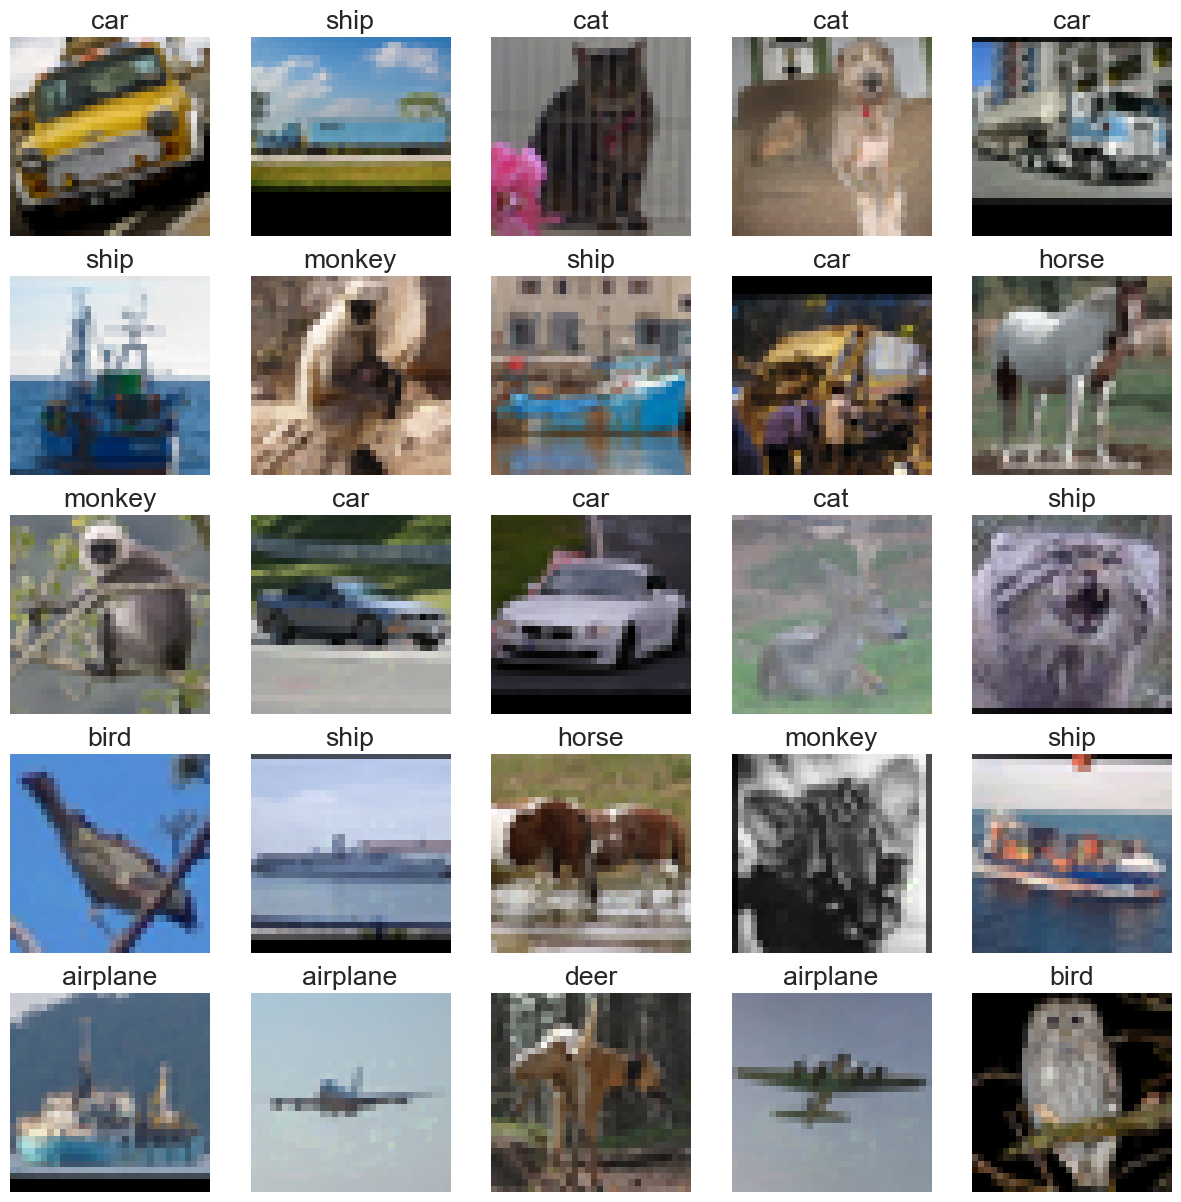

In [7]:
#Predict Class
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)
pred_class = np.argmax(net.predict(x_test), axis = 1)

fig, axes = plt.subplots(5,5, figsize = (15, 15))

x_test_show = (x_test - x_test.min(axis = 0)) / (x_test.max(axis = 0) - x_test.min(axis = 0))

for ind in range(25):
    plt.subplot(5,5,ind + 1)
    plt.imshow(x_test_show[ind])
    plt.title(classes[pred_class[ind]])
    plt.axis('off')

### 1d. Questions

**Question 1:** What accuracy do you get on the STL-10 test set? Briefly summarize any non-default hyperparameters that you used to obtain this result.

**Question 2:** How do the loss and accurary results compare to the CNN project?

**Question 3:** Identify a few misclassifications. Is there a discernable pattern?

**Answer 1:**

The accuracy I get on the STL-10 Test Set is 0.44, so 44%. I used the same hyperparameters from the CNN project. Except I used a mini-batch size of 25 because we were training on a small training set and a few epochs to avoid overfitting

**Answer 2:**

Compared to the CNN project, they aren't as good because we built the network from scratch

**Answer 3:**

Most of the misclassifications are classifications that involve animals


## Task 2: Transfer learning

Here you will use TensorFlow to download the pre-trained MobileNetV2 network (you may also use another network like InceptionV3, VGG19, or EfficientNet, but MobileNetV2 likely will run noticeably faster on your machine). We will use transfer learning to accelerate training to solve a novel problem: **the binary classification task of discriminating whether an image is of a hotdog or not.**

### Overview

- Remove the output layer, add a new Dense output layer.
- Freeze (disable) training on all non-output layers.
- Train the last layer on a food dataset. Assess performance. Plot some example images and their classification below.

### 2a. Download and load in hotdot image dataset

Download the **food dataset** from the project website, copy it into a `data` subfolder in your project directory.

Run the below code to load in the hot-dog-or-not dataset. Check the shapes to ensure everything is loaded in correctly. 

In [7]:
ds_base_dir='data/hot-dog-not-hot-dog/numpy/'

hotdog_train_x = np.load(os.path.join(ds_base_dir, 'train_x.npy'))
hotdog_train_y = np.load(os.path.join(ds_base_dir, 'train_y.npy'))
hotdog_test_x = np.load(os.path.join(ds_base_dir, 'test_x.npy'))
hotdog_test_y = np.load(os.path.join(ds_base_dir, 'test_y.npy'))

print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (16000, 96, 96, 3)')
print(f'Test hotdog split shape: {hotdog_test_x.shape}. Should be (4000, 96, 96, 3)')

Training hotdog split shape: (16000, 96, 96, 3). Should be (16000, 96, 96, 3)
Test hotdog split shape: (4000, 96, 96, 3). Should be (4000, 96, 96, 3)


### 2b. Normalize hotdog dataset

Standardize both the train and test dataset according to the **same statistics** computed from the **training set**.

In [8]:
mean = np.mean(hotdog_train_x, axis = 0)
std = np.std(hotdog_train_x, axis = 0)

hotdog_train_x = (hotdog_train_x - mean) / std
hotdog_test_x = (hotdog_test_x - mean) / std

### 2c. Create hotdog validation set

Set aside the last 20% of the training set as the validation set

In [ ]:
#Splitting the training set

#Shuffling the training data

print(hotdog_train_y.shape)

copy_x = hotdog_train_x.copy()
copy_y = hotdog_train_y.copy()

rand_ind = np.random.permutation(hotdog_train_x.shape[0])

copy_x = copy_x[rand_ind]
copy_y = copy_y[rand_ind]

hotdog_val_x = copy_x[0:3200, :]
hotdog_val_y = copy_y[0:3200]

hotdog_train_x = copy_x[3200:, :]
hotdog_train_y = copy_y[3200:]



(16000,)


In [11]:
print(f'Validation hotdog split shape: {hotdog_val_x.shape}. Should be (3200, 96, 96, 3)')
print(f'Training hotdog split shape: {hotdog_train_x.shape}. Should be (12800, 96, 96, 3)')

Validation hotdog split shape: (3200, 96, 96, 3). Should be (3200, 96, 96, 3)
Training hotdog split shape: (12800, 96, 96, 3). Should be (12800, 96, 96, 3)


### 2d. Load in pre-trained MobileNetV2 network.

Load in a pre-trained MobileNetV2 network (look up constructor in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2) or look at the tutorial from class) and set it to a variable called `model`. Remember to make the network not trainable. Calling the `summary()` method on the network object should show you a table with many rows. The top and bottom rows should be:

    Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
    ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
    │ input_layer_19      │ (None, 96, 96, 3) │          0 │ -                 │
    │ (InputLayer)        │                   │            │            
                                        
    ├─────────────────────┼───────────────────┼────────────┼───────────────────┤
    │ out_relu (ReLU)     │ (None, 3, 3,      │          0 │ Conv_1_bn[0][0]   │
    │                     │ 1280)             │            │                   │  
                                                                                                  
==================================================================================================

and you should see the following at the bottom:

    Total params: 2,257,984 (8.61 MB)
    Trainable params: 0 (0.00 B)
    Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
#Constructing the model and setting training to False
input_nonbatch_shape = hotdog_train_x.shape[1:]
model = tf.keras.applications.MobileNetV2(input_shape=input_nonbatch_shape, include_top=False, weights='imagenet')
model.trainable = False

#Summary function
model.summary()


Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2e. Create augmented model

Create a new `keras::Sequential` augmented model with an output layer that has the correct number of units to deal with the hot-dog or not problem with your choice of optimizer, an appropriate loss, and metric(s).

#### Helpful links

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW

https://www.tensorflow.org/api_docs/python/tf/losses

In [16]:
#Creating the augmented model
aug_net = tf.keras.Sequential(
    [
        model, 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 1, activation='sigmoid')
    ]
)

aug_net.summary()

aug_net.compile(optimizer='adamw', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        11,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,505 (8.66 MB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2f. Questions

**Question 4:** What is the accuracy and loss for the network with the untrained output layer on the test set? Explain why you got the accuracy value that you did.

**Question 5:** Briefly defend your choice of number of units in the output layer.

**Answer 4:**

With an untrained output layer, I get a loss of 1.24 and an accuracy of 0.47. I got this accuracy because the output of the augmented layer hasn't seen any training data yet, so the result would understandable by around 50/50 in classications. 

**Answer 5:**

I used 1 unit in the outplayer because this is a binary classification data set, with 0 being not a hotdog and 1 being a hotdog

In [17]:
#Accuracy and Loss of Test Set
loss, acc = aug_net.evaluate(hotdog_test_x, hotdog_test_y)
print(f'Loss on Test Set: {loss}, Accuracy on Test Set: {acc}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.4841 - loss: 1.2346
Loss on Test Set: 1.2452396154403687, Accuracy on Test Set: 0.47699999809265137


### 2g. Fit the augmented model on the hotdog training data

Setting the verbose optional parameter to 2 will give you helpful printouts of performance on the validation set as it completes every epoch of training.

#### Training goal

You should aim to achieve at least 85% accuracy on the validation set. If everything is set up properly, you should only need to train for a very small number of epochs.


#### Note

If training time is taking much more than a few minutes per epoch on your computer, you could try reducing the number of data samples in train and validation. For example, by default train `N = 12800`. Try `N = 6400` instead. You could do the same for the validation set.

In [20]:
#Compiling, Fit, and Evaluate
aug_net.compile(optimizer='adamw', loss='binary_crossentropy', metrics=['accuracy'])
history = aug_net.fit(hotdog_train_x, hotdog_train_y, batch_size=128, epochs=10, validation_data=(hotdog_val_x, hotdog_val_y))
loss, acc = aug_net.evaluate(hotdog_test_x, hotdog_test_y)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.8476 - loss: 0.3429 - val_accuracy: 0.8747 - val_loss: 0.3014
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.9293 - loss: 0.1785 - val_accuracy: 0.9044 - val_loss: 0.2498
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - accuracy: 0.9598 - loss: 0.1271 - val_accuracy: 0.9178 - val_loss: 0.2188
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 386ms/step - accuracy: 0.9723 - loss: 0.0970 - val_accuracy: 0.9013 - val_loss: 0.2704
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 388ms/step - accuracy: 0.9764 - loss: 0.0829 - val_accuracy: 0.8256 - val_loss: 0.4768
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 360ms/step - accuracy: 0.9596 - loss: 0.1031 - val_accuracy: 0.9275 - val_loss: 0.2026
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.9513 - loss: 0.1178 - val_accuracy: 0.9153 - val_loss: 0.2389
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 362ms/step - accuracy: 0.9688 - loss: 0

### 2h. Plot hotdog results

Produce 2 high quality plots showing the following:

- Training and validation loss over epoch.
- Training and validation accuracy over epoch.

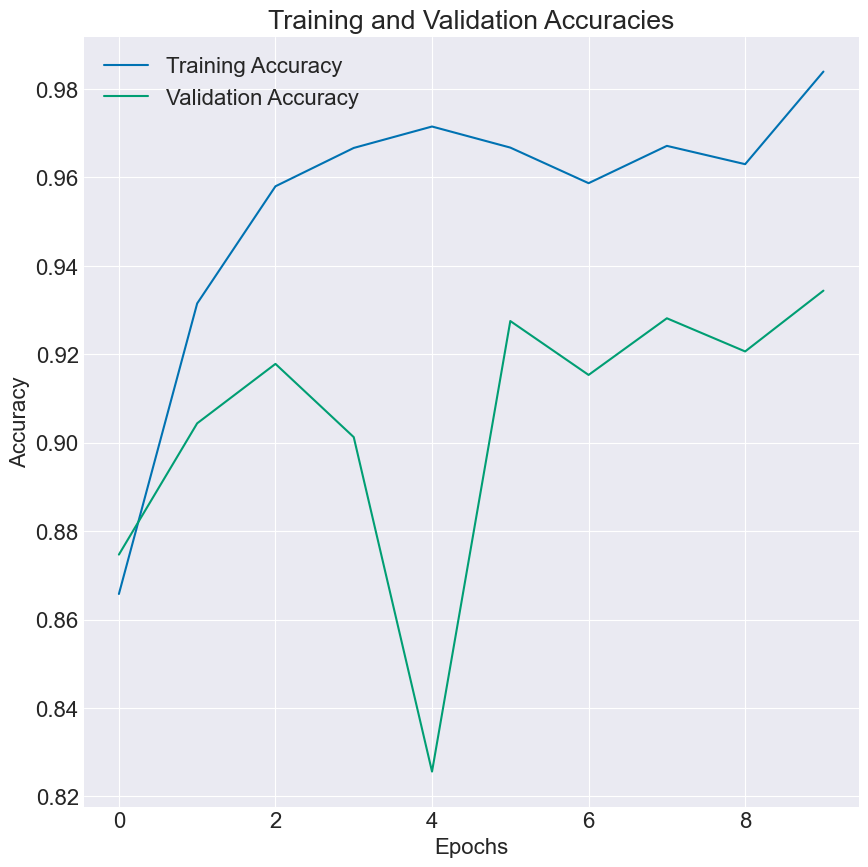

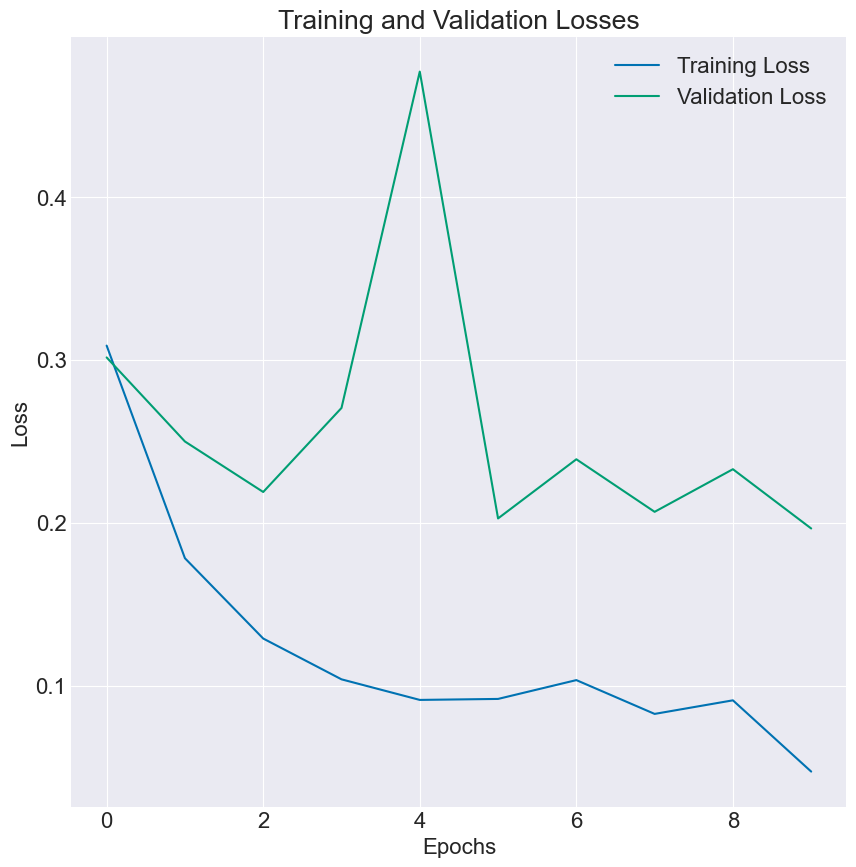

In [21]:
#Training and Validation Accuracy
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')

plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training and Validation Loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2i. Visualize predictions on test set

Use your trained hotdog classifier to get the predicted classes for the first 25 **test set** samples. Then create a 5x5 grid of the first 25 test samples and label each with the predicted class string (English label, not an int code).
- If the prediction is correct, color the label *blue*.
- If the prediction is incorrect, color the label *red*.

**Note:**
- Depending on how you get the network predictions, TensorFlow may give you a vector of class probabilities. This could be shape `(N, 2)` or `(N,)`, depending on the output layer activation function that you used. Remember that if you have these probabilities, you need to recover the predicted class index (e.g. `0`, `1`) before you can label your plots.
- If `imshow` gives you warnings about clipping, check the range of the test samples. If your max is slightly higher than 1, either ignore the warning or divide by the max. 

125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step
1
[0.372]
[0.157]
[0.976]
[0.635]
[0.106]
[0.]
[0.]
[0.981]
[0.999]
[0.305]
[0.665]
[1.]
[0.993]
[0.077]
[0.001]
[0.]
[0.858]
[0.998]
[0.181]
[1.]
[0.94]
[0.073]
[0.]
[0.966]
[0.035]


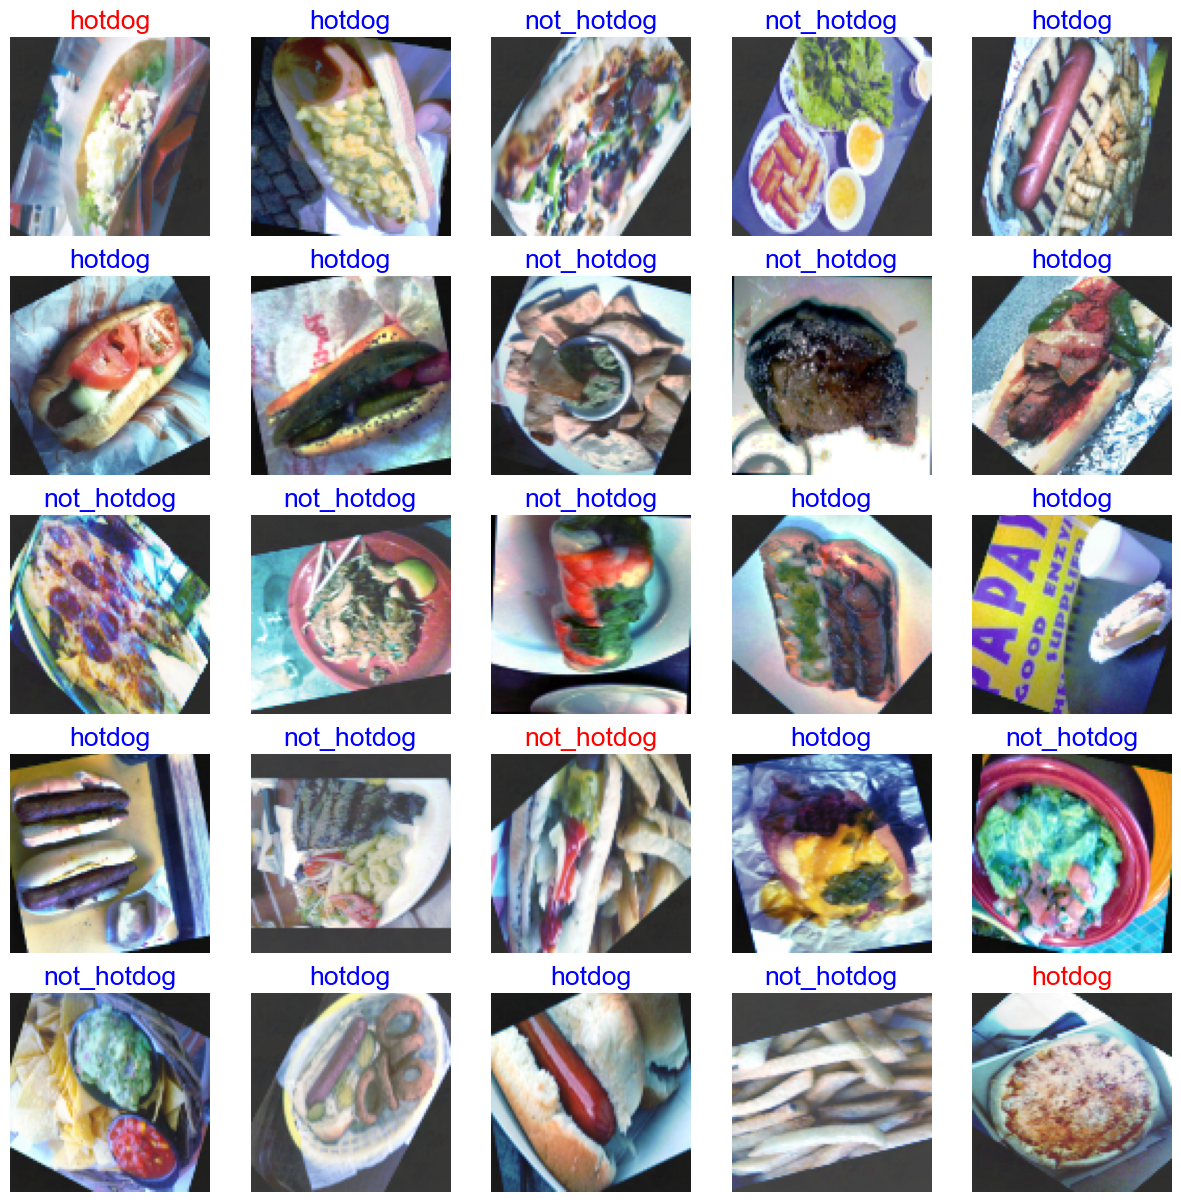

In [ ]:
#Predict Class
pred_class = aug_net.predict(hotdog_test_x)
classes = ['hotdog', 'not_hotdog']
fig, axes = plt.subplots(5,5, figsize = (15, 15))
print(hotdog_test_y[0])
hotdog_test_x = (hotdog_test_x - hotdog_test_x.min(axis = 0)) / (hotdog_test_x.max(axis = 0) - hotdog_test_x.min(axis = 0))

for ind in range(25):
    plt.subplot(5,5,ind + 1)
    plt.imshow(hotdog_test_x[ind])

    #Inverse the if statements cause pred_class[ind] == probability and hotdog_test_y[ind] == 0 or 1
    if pred_class[ind] >= 0.5:
        temp_class = 1
        if temp_class == hotdog_test_y[ind]:
            plt.title(classes[temp_class], color='blue')
        else:
            plt.title(classes[temp_class], color='red')
    else:
        temp_class = 0
        if temp_class == hotdog_test_y[ind]:
            plt.title(classes[temp_class], color='blue')
        else:
            plt.title(classes[temp_class], color='red')
    plt.axis('off')